# 血压数据

In [2]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

### 读取血压数据

In [4]:
bpdata = pd.read_csv('bp_xiugai.csv')
bpdata.head()

,charttime,subject_id,icustay_id,diasbp,ni_dbp,sysbp,ni_sbp,meanbp,ni_mbp,gender,admission_age
0,2100-06-14 07:36:00,29156,293407,NaN,NaN,NaN,NaN,NaN,NaN,M,72.1277
1,2100-06-14 08:00:00,29156,293407,NaN,76.0,NaN,108.0,NaN,81.0,M,72.1277
2,2100-06-14 09:00:00,29156,293407,NaN,53.0,NaN,101.0,NaN,64.0,M,72.1277
3,2100-06-14 10:00:00,29156,293407,NaN,60.0,NaN,112.0,NaN,74.0,M,72.1277
4,2100-06-14 10:45:00,29156,293407,NaN,63.0,NaN,107.0,NaN,73.0,M,72.1277


### 处理年龄

In [5]:
for i in range(len(bpdata)):
    if bpdata.loc[i,'admission_age']>200:
        bpdata.loc[i,'admission_age']=91.4

In [8]:
bpdata.describe()

,subject_id,icustay_id,diasbp,ni_dbp,sysbp,ni_sbp,meanbp,ni_mbp,admission_age
count,361784.000000,361784.000000,177990.000000,125284.000000,178032.000000,125362.000000,180548.000000,124481.000000,361784.000000
mean,38530.721511,250706.833998,60.076518,60.323514,121.024585,119.765094,80.517167,76.847126,65.539023
std,29272.087810,29048.114157,13.843041,15.339751,25.111993,22.537436,18.226929,15.444191,16.916993
min,3.000000,200003.000000,1.000000,0.610000,1.000000,0.750000,1.000000,7.000000,18.022100
25%,14177.000000,225825.000000,51.000000,50.000000,103.000000,103.000000,68.000000,66.000000,54.771525
50%,28190.000000,250793.000000,58.000000,59.000000,118.000000,117.000000,78.000000,75.000000,68.095900
75%,62828.000000,276116.000000,68.000000,70.000000,137.000000,134.000000,90.000000,86.000000,78.720200
max,99995.000000,299995.000000,286.000000,212.000000,323.000000,252.000000,299.000000,217.000000,91.400000


### 处理哑变量

In [13]:
dummy_col = bpdata[['gender']] #eatract the bp data
dummies_feature = pd.get_dummies(dummy_col,prefix=['sex'])#deal with the dummy data
bp = bpdata.drop(['gender'], axis=1)#drop original dummy column
data_dummied = dummies_feature.join(bp)#combine the processed dummy feature to the whole dataset
data_dummied.head()

,sex_F,sex_M,charttime,subject_id,icustay_id,diasbp,ni_dbp,sysbp,ni_sbp,meanbp,ni_mbp,admission_age
0,0,1,2100-06-14 07:36:00,29156,293407,NaN,NaN,NaN,NaN,NaN,NaN,72.1277
1,0,1,2100-06-14 08:00:00,29156,293407,NaN,76.0,NaN,108.0,NaN,81.0,72.1277
2,0,1,2100-06-14 09:00:00,29156,293407,NaN,53.0,NaN,101.0,NaN,64.0,72.1277
3,0,1,2100-06-14 10:00:00,29156,293407,NaN,60.0,NaN,112.0,NaN,74.0,72.1277
4,0,1,2100-06-14 10:45:00,29156,293407,NaN,63.0,NaN,107.0,NaN,73.0,72.1277


### 处理舒张压

In [15]:
dias_data = data_dummied[['charttime','subject_id','icustay_id','diasbp','ni_dbp','sex_F','sex_M','admission_age']]
dias_data.head()

,charttime,subject_id,icustay_id,diasbp,ni_dbp,sex_F,sex_M,admission_age
0,2100-06-14 07:36:00,29156,293407,NaN,NaN,0,1,72.1277
1,2100-06-14 08:00:00,29156,293407,NaN,76.0,0,1,72.1277
2,2100-06-14 09:00:00,29156,293407,NaN,53.0,0,1,72.1277
3,2100-06-14 10:00:00,29156,293407,NaN,60.0,0,1,72.1277
4,2100-06-14 10:45:00,29156,293407,NaN,63.0,0,1,72.1277


### 提取完整数据集

In [18]:
data_complete_dias = dias_data.dropna()
data_complete_dias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19805 entries, 205 to 361779
Data columns (total 8 columns):
charttime        19805 non-null object
subject_id       19805 non-null int64
icustay_id       19805 non-null int64
diasbp           19805 non-null float64
ni_dbp           19805 non-null float64
sex_F            19805 non-null uint8
sex_M            19805 non-null uint8
admission_age    19805 non-null float64
dtypes: float64(3), int64(2), object(1), uint8(2)
memory usage: 1.1+ MB


### 统计分析

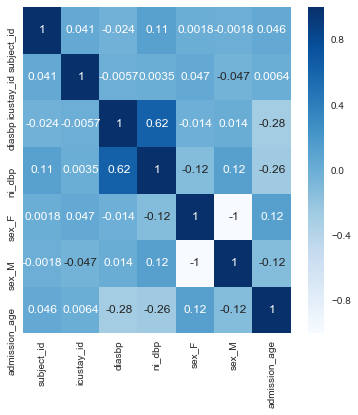

             diasbp        ni_dbp  admission_age
count  19805.000000  19805.000000   19805.000000
mean      61.006286     56.155870      65.630914
std       16.974286     14.942958      16.041832
min        3.000000     10.000000      18.139100
25%       50.000000     46.000000      54.963000
50%       58.000000     54.000000      68.201800
75%       69.000000     65.000000      77.957800
max      281.000000    142.000000      91.400000


In [20]:
coef = data_complete_dias.corr()
plt.subplots(figsize=(6, 6))
sn.heatmap(coef, annot=True, cmap="Blues")
plt.show()
print(data_complete_dias[['diasbp','ni_dbp','admission_age']].describe())

### 构建插值模型

In [25]:
from sklearn.ensemble import RandomForestRegressor

colnames = ['sex_F','sex_M','diasbp','admission_age']
x_dias = data_complete_dias[colnames]
y_dias = data_complete_dias['ni_dbp']

rf_dias = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf_dias.fit(x_dias,y_dias)
R2_rf_dias = rf_dias.score(x_dias,y_dias)

In [27]:
R2_rf_dias

0.8740019145666706

### 插值

In [12]:
x_dias = datawithdummy_dias[colnames].loc[datawithdummy_dias['ni_dbp'].isnull()]
datawithdummy_dias['ni_dbp'].loc[datawithdummy_dias['ni_dbp'].isnull()]=rf_dias.predict(x_dias)
data_dias['ni_dbp'] = datawithdummy_dias['ni_dbp']
data_dias.to_csv('M:/AKIdata/nidbp_full.csv')

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
data_dias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283319 entries, 0 to 283318
Data columns (total 9 columns):
icustay_id        283319 non-null int64
starttime         283319 non-null object
charttime         283319 non-null object
diasbp            177957 non-null float64
ni_dbp            283319 non-null float64
dbp_com           283319 non-null float64
age               283319 non-null float64
gender            283319 non-null object
admission_type    283319 non-null object
dtypes: float64(4), int64(1), object(4)
memory usage: 19.5+ MB


## 处理收缩压

In [33]:
data_sys =  pd.read_csv('M:/AKIdata/sysbp.csv')
data_sys.head()

,icustay_id,starttime,charttime,sysbp,ni_sbp,sbp_com,age,gender,admission_type
0,200003,2199-08-09 04:20:00,2199-08-08 05:00:00,113.0,NaN,113.0,48.296,M,EMERGENCY
1,200003,2199-08-09 04:20:00,2199-08-08 06:00:00,122.0,NaN,122.0,48.296,M,EMERGENCY
2,200003,2199-08-09 04:20:00,2199-08-08 07:00:00,112.0,NaN,112.0,48.296,M,EMERGENCY
3,200003,2199-08-09 04:20:00,2199-08-08 08:00:00,115.0,NaN,115.0,48.296,M,EMERGENCY
4,200003,2199-08-09 04:20:00,2199-08-08 09:00:00,120.0,NaN,120.0,48.296,M,EMERGENCY


### 处理年龄

In [34]:
for i in range(len(data_sys)):
    if data_sys.loc[i,'age']>200:
        data_sys.loc[i,'age']=91.4

### 处理哑变量

In [36]:
sysbp = data_sys[['sysbp', 'ni_sbp', 'age', 'gender', 'admission_type']]
dummy_feature_sys = sysbp[['gender','admission_type']]
dummies_sys = pd.get_dummies(dummy_feature_sys,prefix=['sex','type'])
sysbp = sysbp.drop(['gender', 'admission_type'], axis=1)
datawithdummy_sys = dummies_sys.join(sysbp)

### 提取完整数据集

In [39]:
data_complete_sys = datawithdummy_sys.dropna()

### 统计分析

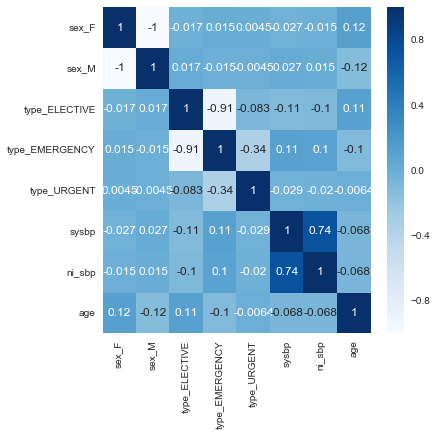

              sysbp        ni_sbp           age
count  19883.000000  19883.000000  19883.000000
mean     116.500855    116.106385     65.616151
std       30.125678     23.472609     16.030569
min        2.000000      0.750000     18.139100
25%       95.000000     99.000000     54.786800
50%      111.000000    112.000000     68.198700
75%      134.000000    130.000000     77.957800
max      285.000000    232.000000     91.400000


In [40]:
coef_sys = data_complete_sys.corr()
plt.subplots(figsize=(6, 6))
sn.heatmap(coef_sys, annot=True, cmap="Blues")
plt.show()
print(data_complete_sys[['sysbp','ni_sbp','age']].describe())

### 插值模型

In [41]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

colnames = ['sex_F','sex_M','type_EMERGENCY','type_ELECTIVE','type_URGENT','sysbp','age']
x_sys = data_complete_sys[colnames]
y_sys = data_complete_sys['ni_sbp']

rf_sys = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf_sys.fit(x_sys,y_sys)
R2_rf_sys = rf_sys.score(x_sys,y_sys)


In [42]:
R2_rf_sys

0.9229806000632818

In [44]:
x_sys = datawithdummy_sys[colnames].loc[datawithdummy_sys['ni_sbp'].isnull()]
datawithdummy_sys['ni_sbp'].loc[datawithdummy_sys['ni_sbp'].isnull()]=rf_sys.predict(x_sys)
data_sys['ni_sbp'] = datawithdummy_sys['ni_sbp']
data_sys.to_csv('M:/AKIdata/nisbp_full.csv')

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [43]:
datawithdummy_sys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283403 entries, 0 to 283402
Data columns (total 8 columns):
sex_F             283403 non-null uint8
sex_M             283403 non-null uint8
type_ELECTIVE     283403 non-null uint8
type_EMERGENCY    283403 non-null uint8
type_URGENT       283403 non-null uint8
sysbp             177999 non-null float64
ni_sbp            125287 non-null float64
age               283403 non-null float64
dtypes: float64(3), uint8(5)
memory usage: 7.8 MB


In [45]:
data_sys.describe()

,icustay_id,sysbp,ni_sbp,sbp_com,age
count,283403.000000,177999.000000,283403.000000,283403.000000,283403.000000
mean,250555.786008,121.046534,119.041545,120.803464,65.713306
std,28840.044431,25.099840,19.569591,23.679678,16.737118
min,200003.000000,1.000000,0.750000,1.000000,18.022100
25%,225825.000000,103.000000,105.000000,103.000000,55.250300
50%,250649.000000,118.000000,116.817082,118.000000,68.164800
75%,275499.000000,137.000000,131.000000,136.000000,78.780900
max,299995.000000,323.000000,252.000000,323.000000,91.400000


## 处理平均压

In [2]:
data_mean =  pd.read_csv('M:/AKIdata/meanbp.csv')
data_mean.head()

,icustay_id,starttime,charttime,meanbp,ni_mbp,mbp_com,age,gender,admission_type
0,200003,2199-08-09 04:20:00,2199-08-08 05:00:00,78.0,NaN,78.0,48.296,M,EMERGENCY
1,200003,2199-08-09 04:20:00,2199-08-08 06:00:00,82.0,NaN,82.0,48.296,M,EMERGENCY
2,200003,2199-08-09 04:20:00,2199-08-08 07:00:00,76.0,NaN,76.0,48.296,M,EMERGENCY
3,200003,2199-08-09 04:20:00,2199-08-08 08:00:00,79.0,NaN,79.0,48.296,M,EMERGENCY
4,200003,2199-08-09 04:20:00,2199-08-08 09:00:00,81.0,NaN,81.0,48.296,M,EMERGENCY


## 处理年龄

In [3]:
for i in range(len(data_mean)):
    if data_mean.loc[i,'age']>200:
        data_mean.loc[i,'age']=91.4

### 处理哑变量

In [4]:
meanbp = data_mean[['meanbp', 'ni_mbp', 'age', 'gender', 'admission_type']]
dummy_feature_mean = meanbp[['gender','admission_type']]
dummies_mean = pd.get_dummies(dummy_feature_mean,prefix=['sex','type'])
meanbp = meanbp.drop(['gender', 'admission_type'], axis=1)
datawithdummy_mean = dummies_mean.join(meanbp)

### 提取完整数据集

In [7]:
data_complete_mean = datawithdummy_mean.dropna()

### 统计分析

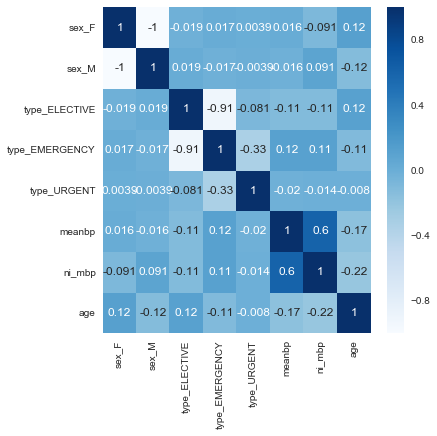

             meanbp        ni_mbp           age
count  20637.000000  20637.000000  20637.000000
mean      80.275234     73.931943     65.549776
std       23.592862     15.700091     16.112215
min        1.000000     18.666700     18.139100
25%       65.000000     63.000000     54.786800
50%       76.000000     71.000000     68.020200
75%       90.000000     82.666702     78.022200
max      294.000000    158.000000     91.400000


In [8]:
coef_mean = data_complete_mean.corr()
plt.subplots(figsize=(6, 6))
sn.heatmap(coef_mean, annot=True, cmap="Blues")
plt.show()
print(data_complete_mean[['meanbp','ni_mbp','age']].describe())

### 插值模型

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

colnames = ['sex_F','sex_M','type_EMERGENCY','type_ELECTIVE','type_URGENT','meanbp','age']
x_mean = data_complete_mean[colnames]
y_mean = data_complete_mean['ni_mbp']

rf_mean = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
rf_mean.fit(x_mean,y_mean)
R2_rf_mean = rf_mean.score(x_mean,y_mean)

In [26]:
R2_rf_mean

0.9062694181791333

In [27]:
x_mean = datawithdummy_mean[colnames].loc[datawithdummy_mean['ni_mbp'].isnull()]
datawithdummy_mean['ni_mbp'].loc[datawithdummy_mean['ni_mbp'].isnull()]=rf_mean.predict(x_mean)
data_mean['ni_mbp'] = datawithdummy_mean['ni_mbp']
data_mean.to_csv('M:/AKIdata/meanbp_full.csv')

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
data_mean.describe()

,icustay_id,meanbp,ni_mbp,mbp_com,age
count,284270.000000,180482.000000,284270.000000,284270.000000,284270.000000
mean,250553.784852,80.527640,75.302410,79.160136,65.739694
std,28844.095550,18.218732,13.329146,16.769024,16.736440
min,200003.000000,1.000000,7.000000,1.000000,18.022100
25%,225825.000000,68.000000,66.000000,68.000000,55.299700
50%,250580.000000,78.000000,73.611324,77.000000,68.184100
75%,275535.000000,90.000000,83.000000,88.000000,78.800700
max,299995.000000,299.000000,217.000000,299.000000,91.400000
